In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import flax.linen as nn
import matplotlib.pyplot as plt
from flax.linen.activation import softmax
from einops import rearrange
from jax import random
from jax.example_libraries import optimizers
import optax
import sys

In [3]:
# MHSA attention layer
class Attention(nn.Module):

    scale_exp: jnp.float32
    dim: int
    heads: int
    
    def setup(self):
        
        self.c = 1.5 - self.scale_exp # exponent for the scale factor
        kif_qk = nn.initializers.normal(stddev = self.dim**(self.c - 0.5) ) # possibly needs to be scaled with N
        kif_v =  nn.initializers.normal(stddev = 1.0 ) # O_N(1) entries
        # computes key, query, value
        self.qk_layer = nn.Dense(features = 2 * self.heads * self.dim, kernel_init = kif_qk)
        self.v_layer = nn.Dense(features = self.heads * self.dim, kernel_init = kif_v)
        return
    
    def __call__(self,inputs):
        
        qk = self.qk_layer(inputs) / inputs.shape[-1]**(self.c)  # (batch, loc, 3*h*d)
        qk = rearrange( qk, 'b l (h d) -> b h l d' , h = self.heads) # (batch, heads, loc, d )
        q,k = jnp.split(qk, 2, axis = -1) # gives q, k each of shape ( batch, heads, loc, d )
        v = self.v_layer(inputs) / jnp.sqrt( inputs.shape[-1] )
        v = rearrange(v, 'b l (h d) -> b h l d', h = self.heads)
        A = 1.0/ self.dim**(self.scale_exp) * jnp.einsum('ijkl,ijml->ijkm', q, k) # batch x heads x loc x loc
        phi_A = softmax( A, axis=-1 )
        out = jnp.einsum('ijkl,ijlm->ijkm', phi_A, v) # (batch, head, loc, d)  
        out = rearrange(out, 'b h l d -> b l (h d)')
        return out
    
class MLP_Block(nn.Module):

    features: int
    
    @nn.compact
    def __call__(self,x):
        N = self.features
        kif = nn.initializers.normal(stddev = 1.0) # O_N(1) entries
        h = nn.Dense(features = 2*N, kernel_init = kif)(x) / jnp.sqrt(N)
        h = nn.relu(h)
        h = nn.Dense(features = N, kernel_init = kif)(x) / jnp.sqrt(2*N)
        return h
    

class VIT(nn.Module):
    """A simple VIT model"""
  
    dim: int
    heads: int
    depth: int
    patch_size: int
    scale_exp: jnp.float32
    adam_scale: int

    @nn.compact
    def __call__(self, x, train = True):
        N = self.heads * self.dim
        D = 3
        
        
        # patchify images
        x = rearrange(x, 'b (w p1) (h p2) c -> b (w h) (p1 p2 c)', p1 = self.patch_size, p2 = self.patch_size) # (batch, loc, patch_ch_dim )
        
        kif_first= nn.initializers.normal(stddev = N**(-0.5*self.adam_scale) ) # O_N(1) entries
        kif0 = nn.initializers.normal(stddev = 0.0 )
        kif = nn.initializers.normal(stddev = 1.0) # O_N(1) entries

        x = N**(0.5 * self.adam_scale) * nn.Dense(features = N, kernel_init = kif_first)(x) / jnp.sqrt( 3 * self.patch_size**2 )
        x = nn.relu(x)
        for l in range(self.depth):
            h = nn.LayerNorm()(x)
            x = x + 5.0/jnp.sqrt(depth) * Attention(dim = self.dim, scale_exp = self.scale_exp, heads = self.heads)(h)
            h = nn.LayerNorm()(x)
            x = x + 5.0/jnp.sqrt(depth) * MLP_Block(features = N)(h)
            
        # pool over location index
        x = x.mean(axis = 1) # (batch, N)
        x = nn.LayerNorm()(x)
        x = nn.Dense(features = 10, use_bias = False, kernel_init = kif0)(x) / N**(1.0-0.5*self.adam_scale)   # for mean field scaling
        return x

In [65]:
dim = 128
heads = 4
depth = 10
patch_size = 4
model = VIT(dim = dim, heads = heads, depth = depth, patch_size = patch_size, scale_exp = 1.0)

In [ ]:
params = model.init(random.PRNGKey(0), jnp.ones((4,32,32,3)) ) 

out = model.apply(params, X[0:50])
print(out.shape)

In [4]:

data_dir = '/n/holyscratch01/pehlevan_lab/Everyone/cifar-5m-new'
file_name = f"{data_dir}/cifar5m_part{0}.npz"
part0 = np.load(file_name, allow_pickle=True)
X0, y0 = np.load(file_name, allow_pickle=True)

arr = [part0[k] for k in part0.keys()]
X = arr[0]
y = arr[1]
mean = X.mean()
std = X.std()
X = (X - mean) / std
print(y.shape)
print(X.shape)

(1000448,)
(1000448, 32, 32, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

(4, 4, 8, 8, 3)


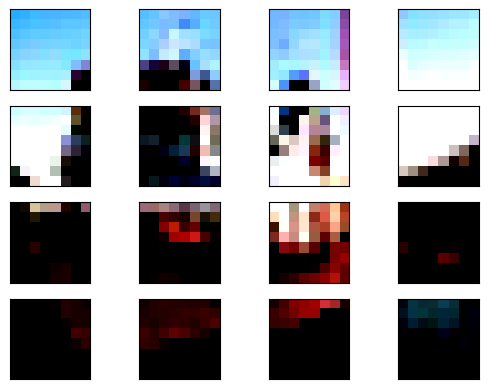

In [8]:
x_re = rearrange(X[0], '(a p1) (b p2) c -> a b p1 p2 c', p1 = 8, p2 = 8)
print(x_re.shape)

plt.figure()
for a in range(4):
    for b in range(4):
        plt.subplot(4,4,4*a+b+1)
        plt.imshow(x_re[a,b,:,:,:])
        plt.xticks([])
        plt.yticks([])
plt.show()

## Train VIT on CIFAR-5M

In [11]:
def get_data(dset_count):
    
    data_dir = '/n/holyscratch01/pehlevan_lab/Everyone/cifar-5m-new'
    file_name = f"{data_dir}/cifar5m_part{dset_count}.npz"
    part0 = np.load(file_name, allow_pickle=True)

    arr = [part0[k] for k in part0.keys()]
    X = arr[0]
    y = arr[1]
    mean = X.mean()
    std = X.std()
    X = (X - mean) / std
    return X, y

def train_model(param_args, opt_args, data = None, adam = False):

    dim, heads, depth, patch_size, scale_exp = param_args
    T, batch, gamma, lr = opt_args
    
    if adam:
        adam_scale = 1.0
        opt_init, opt_update, get_params = optimizers.adam( lr / jnp.sqrt(heads * dim) , eps = 1e-20)

    else:
        adam_scale = 0.0
        opt_init, opt_update, get_params = optimizers.sgd( heads * dim * gamma**2 *  lr)

    model = VIT(dim = dim, heads = heads, depth = depth, patch_size = patch_size, scale_exp = scale_exp, adam_scale = adam_scale)

    params = model.init(random.PRNGKey(0), jnp.ones((4,32,32,3)) )['params']
                                                               
    opt_state = opt_init(params)

    shift_fn = jax.jit(lambda p, x: (model.apply({'params':p}, x) - model.apply({'params':params}, x)) / gamma)
    #shift_fn = jax.jit(lambda p, x: model.apply({'params':p}, x) / gamma)
    loss_fn = jax.jit(lambda params, Xb, yb: optax.softmax_cross_entropy_with_integer_labels(logits=shift_fn(params, Xb), labels=yb).mean())
    grad_fn = jax.jit(jax.grad(loss_fn))


    losses = []
    
    loss_t = 0.0
    dset_count = 0
    
    if data != None:
        X,y = data
    
    for t in range(T):
    
        if data == None:
            if t == 0:
                X, y = get_data(dset_count)
                ind = 0
            elif ind+batch >= X.shape[0]:
            
                if dset_count < 4:
                    dset_count += 1
                    X, y = get_data(dset_count)
                    ind = 0
                else:
                    return losses
        else:
            ind = (t*batch) % X.shape[0]
        Xt = X[ind:ind+batch]
        yt = y[ind:ind+batch]
        ind += batch
        
        loss_t = loss_t * t/(t+1) + 1.0/(t+1) * loss_fn(get_params(opt_state), Xt, yt)
        losses += [loss_t]
        if t % 10 == 0:
            sys.stdout.write(f'\r loss = {loss_t}')
        opt_state = opt_update(t,grad_fn(get_params(opt_state), Xt, yt),opt_state)
        
    return losses

In [111]:
dimvals = [4, 8, 16, 32, 64]
depth = 6
heads = 4
patch_size = 4
scale_exp = 1.0

T = 2000
lr = 0.2
gamma = 1.0
batch = 128

opt_args = ( T, batch, gamma, lr )

all_losses = []
for i, dim in enumerate(dimvals):
    param_args = (dim, heads, depth, patch_size, scale_exp)
    print(" ")
    print(f"dim = {dim}")
    losses = train_model(param_args, opt_args, (X, y))
    all_losses += [losses] 

 
dim = 4
 loss = 1.7006945610046387 
dim = 8
 loss = 1.6536216735839844 
dim = 16
 loss = 1.5866670608520508 
dim = 32
 loss = 1.5583218336105347 
dim = 64
 loss = 1.5535340309143066

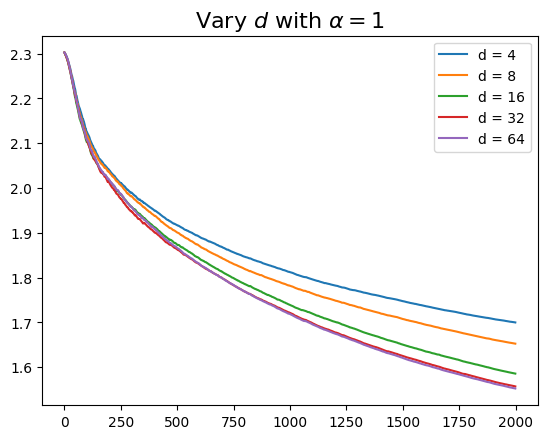

In [113]:
for i, loss in enumerate(all_losses):
    plt.plot(loss, label = f'd = {dimvals[i]}')
plt.legend()
plt.title(r'Vary $d$ with $\alpha = 1$',fontsize = 16)
plt.show()

In [55]:
dim = 32
depth = 5
head_vals = [2,4,8,16,32]
patch_size = 4
scale_exp = 1.0

T = 2000
lr = 0.1
gamma = 0.75
batch = 64

opt_args = ( T, batch, gamma, lr )

all_losses = []
for i, heads in enumerate(head_vals):
    param_args = (dim, heads, depth, patch_size, scale_exp)
    print(" ")
    print(f"dim = {dim}")
    losses = train_model(param_args, opt_args, (X, y))
    all_losses += [losses] 

 
dim = 32
 loss = 1.594199299812317 
dim = 32
 loss = 1.5431138277053833 
dim = 32
 loss = 1.51395583152771 1
dim = 32
 loss = 1.4938876628875732 
dim = 32
 loss = 1.4663385152816772

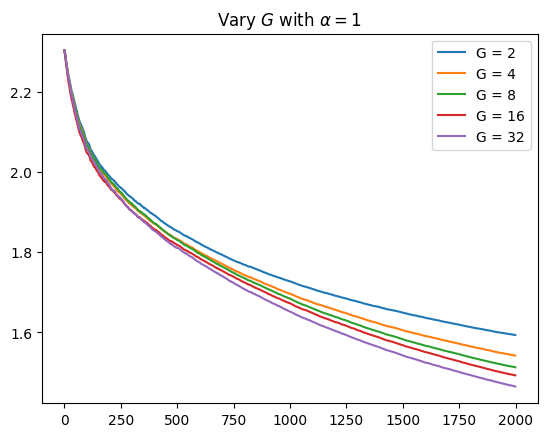

In [59]:
for i, loss in enumerate(all_losses):
    plt.plot(loss, label = f'G = {head_vals[i]}')
plt.legend()
plt.title(r'Vary $G$ with $\alpha = 1$')
plt.show()

In [61]:
dimvals = [4, 8, 16, 32, 64]
depth = 2
heads = 3
patch_size = 4
scale_exp = 0.5

T = 1000

lr = 0.1
gamma = 0.75
batch = 64

opt_args = ( T, batch, gamma, lr )

all_losses = []
for i, dim in enumerate(dimvals):
    param_args = (dim, heads, depth, patch_size, scale_exp)
    print(" ")
    print(f"dim = {dim}")
    losses = train_model(param_args, opt_args)
    all_losses += [losses] 

 
dim = 4
 loss = 1.9258025884628296 
dim = 8
 loss = 1.8374379873275757 
dim = 16
 loss = 1.8021626472473145 
dim = 32
 loss = 1.7546936273574836 
dim = 64
 loss = 1.7541667222976685

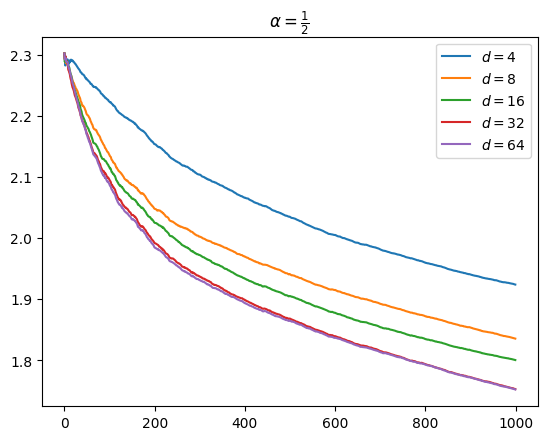

In [63]:
for i, loss in enumerate(all_losses):
    plt.plot(loss, label = r'$d = %d$' % dimvals[i])
plt.legend()
plt.title(r'$\alpha = \frac{1}{2}$')
plt.show()

## LR Transfer

In [12]:
dimvals = [4, 8, 16, 32]
depth = 6
heads = 4
patch_size = 4
scale_exp = 1.0

T = 1000
gamma = 1.0
batch = 128

lrs = jnp.logspace(-1.5, 0.6, 6)

all_losses = []
for i, dim in enumerate(dimvals):
    param_args = (dim, heads, depth, patch_size, scale_exp)
    print(" ")
    print(f"dim = {dim}")
    
    losses_i = []
    for j, lr in enumerate(lrs):
        opt_args = ( T, batch, gamma, lr )
        losses_i += [train_model(param_args, opt_args, (X, y))]        
    all_losses += [losses_i] 
    
    

 
dim = 4
 loss = nan893662452697754 
dim = 8
 loss = nan .1303710937555
dim = 16
 loss = nan3.6650390625873 
dim = 32
 loss = nan739264011383057

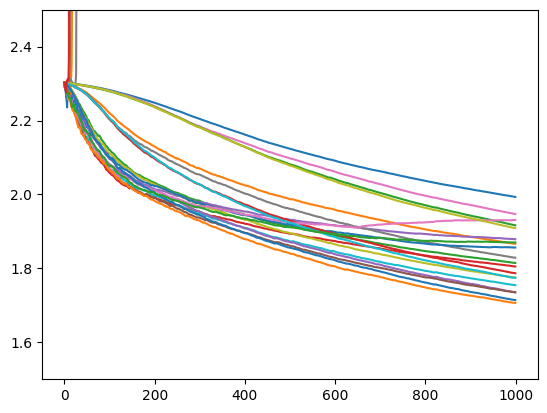

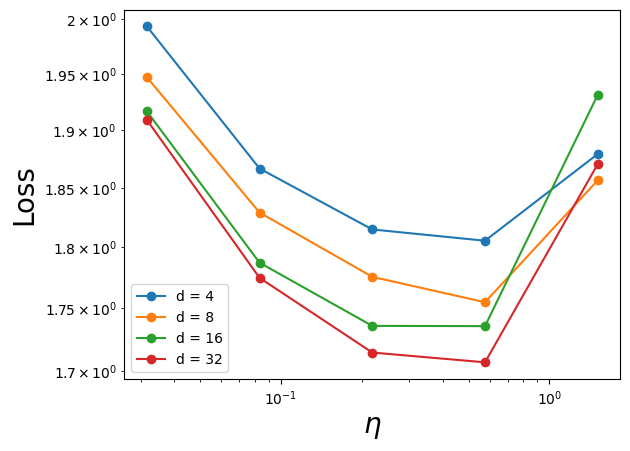

In [13]:
final_losses = []
for loss in all_losses:
    final_i = []
    for loss_eta in loss:
        plt.plot(loss_eta)
        final_i += [loss_eta[-1]]
    final_losses += [final_i]
plt.ylim([1.5,2.5])
plt.show()


for i,loss in enumerate(final_losses):
    plt.loglog(lrs, loss, '-o', label = f'd = {dimvals[i]}')
plt.legend()
plt.xlabel(r'$\eta$',fontsize = 20)
plt.ylabel(r'Loss', fontsize = 20)
plt.show()

In [14]:
dimvals = [4, 8, 16, 32]
depth = 6
heads = 4
patch_size = 4
scale_exp = 0.5

T = 1000
gamma = 1.0
batch = 128

lrs = jnp.logspace(-1.5, 0.6, 6)

all_losses_half = []
for i, dim in enumerate(dimvals):
    param_args = (dim, heads, depth, patch_size, scale_exp)
    print(" ")
    print(f"dim = {dim}")
    
    losses_i = []
    for j, lr in enumerate(lrs):
        opt_args = ( T, batch, gamma, lr )
        losses_i += [train_model(param_args, opt_args, (X, y))]        
    all_losses_half += [losses_i] 
    
    

 
dim = 4
 loss = nan865818023681644 
dim = 8
 loss = nan5.5703125066406 
dim = 16
 loss = nan2669056.0146973 
dim = 32
 loss = nan934746742248535

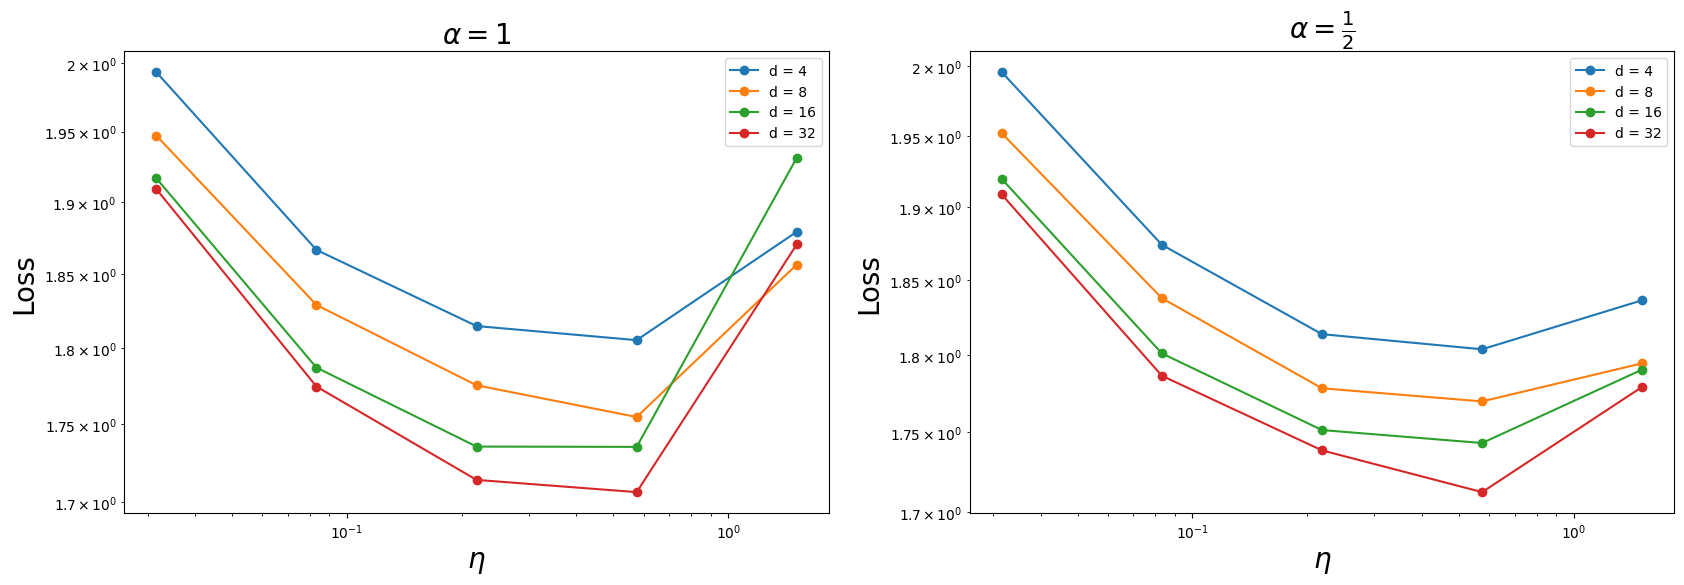

In [23]:
final_half= []
for i,loss in enumerate(all_losses_half):
    final_i = []
    for loss_eta in loss:
         
        final_i += [loss_eta[-1]]
    final_half += [final_i]
 


plt.figure(figsize = (20,6))
plt.subplot(1,2,1)
for i,loss in enumerate(final_losses):
    plt.loglog(lrs, loss, '-o', label = f'd = {dimvals[i]}')
plt.legend()
plt.xlabel(r'$\eta$',fontsize = 20)
plt.ylabel(r'Loss', fontsize = 20)
plt.title(r'$\alpha = 1$',fontsize = 20)

plt.subplot(1,2,2)
for i,loss in enumerate(final_half):
    plt.loglog(lrs, loss, '-o', label = f'd = {dimvals[i]}')
plt.legend()
plt.xlabel(r'$\eta$',fontsize = 20)
plt.ylabel(r'Loss', fontsize = 20)
plt.title(r'$\alpha = \frac{1}{2}$',fontsize = 20)

plt.show()

In [81]:
dim = 16
depth = 6
head_vals = [2,4,8,16]
patch_size = 4
scale_exp = 1.0

T = 2500
gamma = 1.0
batch = 64

lrs = jnp.logspace(-2.5, 0.0, 6)

all_losses = []
for i, heads in enumerate(head_vals):
    param_args = (dim, heads, depth, patch_size, scale_exp)
    print(" ")
    print(f"dim = {dim}")
    
    losses_i = []
    for j, lr in enumerate(lrs):
        opt_args = ( T, batch, gamma, lr )
        losses_i += [train_model(param_args, opt_args, (X, y))]        
    all_losses += [losses_i] 
    
    

 
dim = 16
 loss = 1.9536570310592651 
dim = 16
 loss = 1.869832992553711 
dim = 16
 loss = 1.8842977285385132 
dim = 16
 loss = 1.8765273094177246

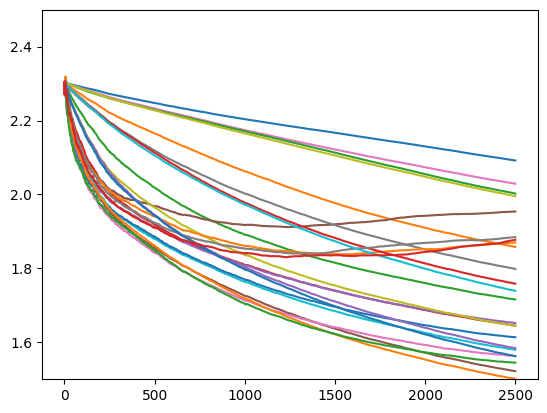

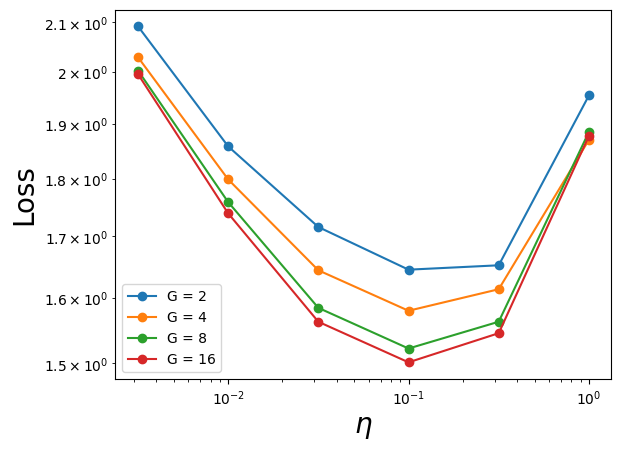

In [82]:
final_losses = []
for loss in all_losses:
    final_i = []
    for loss_eta in loss:
        plt.plot(loss_eta)
        final_i += [loss_eta[-1]]
    final_losses += [final_i]
plt.ylim([1.5,2.5])
plt.show()


for i,loss in enumerate(final_losses):
    plt.loglog(lrs, loss, '-o', label = f'G = {head_vals[i]}')
plt.legend()
plt.xlabel(r'$\eta$',fontsize = 20)
plt.ylabel(r'Loss', fontsize = 20)
plt.show()

# Implement ADAM

In [6]:

dimvals = [4, 8, 16, 32, 64]
depth = 4
heads = 4
patch_size = 4
scale_exp = 1.0

T = 2000
lr = 0.1
gamma = 0.8
batch = 64

opt_args = ( T, batch, gamma, lr )
all_losses = []
for i, dim in enumerate(dimvals):
    param_args = (dim, heads, depth, patch_size, scale_exp)
    print(" ")
    print(f"dim = {dim}")
    losses = train_model(param_args, opt_args, (X, y), adam = True)
    all_losses += [losses] 

 
dim = 4
 loss = 1.5709433555603027 
dim = 8
 loss = 1.5087578296661377 
dim = 16
 loss = 1.4715726375579834 
dim = 32
 loss = 1.4491610527038574 
dim = 64
 loss = 1.4471646547317505

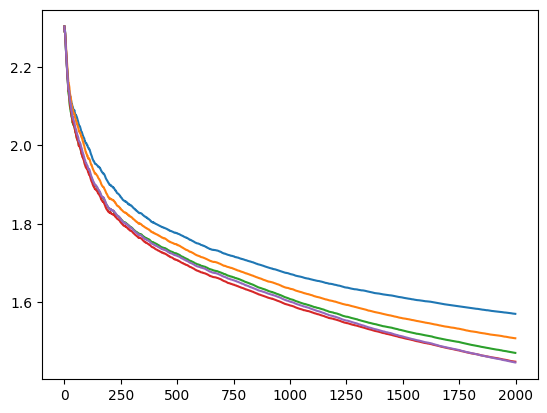

In [7]:
for loss in all_losses:
    plt.plot(loss)
plt.show()

In [1]:
dimvals = [4, 8, 16, 32]
depth = 6
heads = 4
patch_size = 4
scale_exp = 1.0

T = 1000
gamma = 1.0
batch = 64

lrs = jnp.logspace(-3.0, 0.6, 7)

all_losses = []
for i, dim in enumerate(dimvals):
    param_args = (dim, heads, depth, patch_size, scale_exp)
    print(" ")
    print(f"dim = {dim}")
    
    losses_i = []
    for j, lr in enumerate(lrs):
        opt_args = ( T, batch, gamma, lr )
        losses_i += [train_model(param_args, opt_args, (X, y), adam = True)]        
    all_losses += [losses_i] 

NameError: name 'jnp' is not defined

ValueError: x and y must have same first dimension, but have shapes (7,) and (6,)

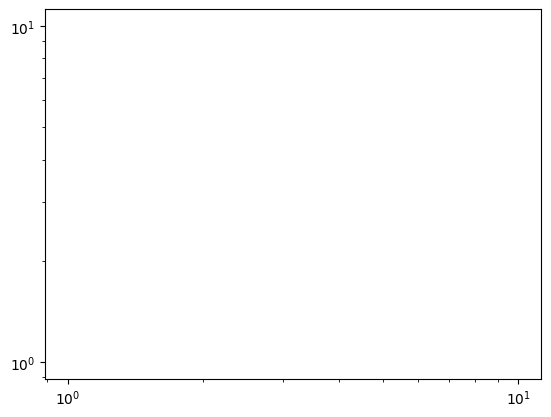

In [122]:

for i,loss in enumerate(final_losses):
    plt.loglog(lrs, loss, '-o', label = f'd = {dimvals[i]}')
plt.legend()
plt.xlabel(r'$\eta$',fontsize = 20)
plt.ylabel(r'Loss', fontsize = 20)
plt.title('HP Transfer Adam',fontsize = 20)
plt.tight_layout()
plt.show()

## Load Saved Results

In [1]:
import argparse
import os
import numpy as np
import matplotlib.pyplot as plt


In [2]:

class Args(argparse.Namespace):
    lr = 0.05
    mom = 0.0
    steps = 2500
    arch = 'vit'
    dataset = 'cifar5m'
    batch_size = 64
    scale_exp = 1.0
    depth = 2
    width = 16
    beta = 4.0
    gamma_zero = 0.1
    heads = 4
    

args = Args()


def get_run_name(args):
    return "model_{}/dataset_{}/lr_{:.4f}/mom_{:.2f}/batch_size_{}/steps_{}/width_{}/heads_{}/depth_{}/scale_exp_{}/beta_{}/gamma_zero_{}".format(args.arch, args.dataset, args.lr, args.mom, args.batch_size, args.steps, args.width, args.heads, args.depth, args.scale_exp, args.beta, args.gamma_zero)


save_dir = '/n/holyscratch01/pehlevan_lab/Users/bbordelon/bbordelon/Learn_gates/cifar_VIT'


## Head sweep 
lrs = np.logspace(-2.5,1.0,12)
heads = [4,8,16,32,64, 128]

all_losses = []
for i,head in enumerate(heads):
    loss_i = []
    for j,lr in enumerate(lrs):
        args.heads = head
        args.lr = lr
        run_name = get_run_name(args)
        save_path = os.path.join(save_dir, run_name.replace("/", "-"))
        
        loss_i += [np.load(save_path + '.npy')]
    all_losses += [loss_i]
    


all_losses_half = []
for i,head in enumerate(heads):
    loss_i = []
    for j,lr in enumerate(lrs):
        args.heads = head
        args.lr = lr
        args.scale_exp = 0.5
        run_name = get_run_name(args)
        save_path = os.path.join(save_dir, run_name.replace("/", "-"))
        
        loss_i += [np.load(save_path + '.npy')]
    all_losses_half += [loss_i]


In [39]:
final_losses =  [ [loss_ij[-1] for loss_ij in loss_i] for loss_i in all_losses ] 
final_losses_half =  [ [loss_ij[-1] for loss_ij in loss_i] for loss_i in all_losses_half ] 

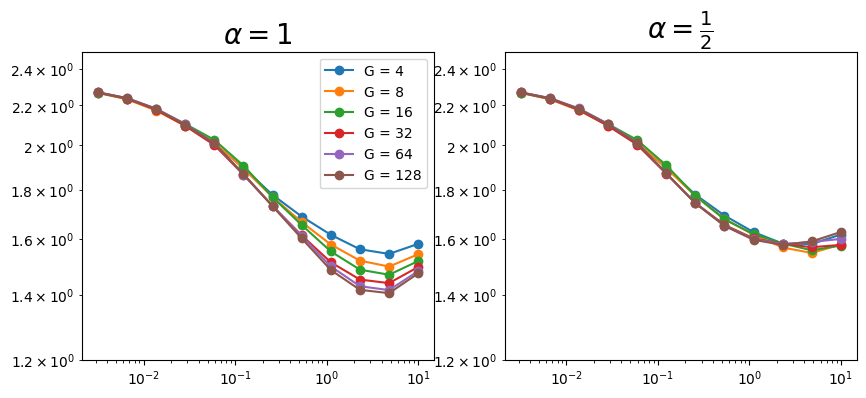

In [40]:
plt.figure(figsize = (10,4))
plt.subplot(1,2,1)

for i,final_i in enumerate(final_losses):
    plt.loglog(lrs, np.array(final_i), '-o', label = f'G = {heads[i]}')
plt.ylim([1.2,2.5])
plt.legend()
plt.title(r'$\alpha = 1$',fontsize = 20)
plt.subplot(1,2,2)
plt.title(r'$\alpha = \frac{1}{2}$',fontsize = 20)
for final_i in final_losses_half:
    plt.loglog(lrs, np.array(final_i), '-o')
plt.ylim([1.2,2.5])
plt.show()

In [3]:

class Args(argparse.Namespace):
    lr = 0.05
    mom = 0.0
    steps = 20000
    arch = 'vit'
    dataset = 'cifar5m'
    batch_size = 64
    scale_exp = 1.0
    depth = 2
    width = 32
    beta = 4.0
    gamma_zero = 0.1
    heads = 4
    

args = Args()



## Head sweep 
lrs = np.logspace(-2.5,1.0,12)
heads = [4,8,16,32,64]

all_losses = []
for i,head in enumerate(heads):
    loss_i = []
    for j,lr in enumerate(lrs):
        args.heads = head
        args.lr = lr
        run_name = get_run_name(args)
        save_path = os.path.join(save_dir, run_name.replace("/", "-"))
        
        loss_i += [np.load(save_path + '.npy')]
    all_losses += [loss_i]
    


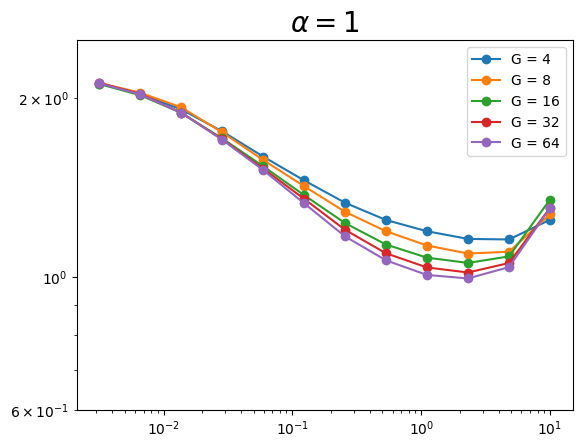

In [4]:
final_losses =  [ [loss_ij[-1] for loss_ij in loss_i] for loss_i in all_losses ] 

for i,final_i in enumerate(final_losses):
    plt.loglog(lrs, np.array(final_i), '-o', label = f'G = {heads[i]}')
plt.ylim([0.6,2.5])
plt.legend()
plt.title(r'$\alpha = 1$',fontsize = 20)
plt.show()